Arthur Liou

UIUC CS445


Image Classification

1. Load and normalize the CIFAR10 or Fashion MNIST training and test datasets using torchvision


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])
# use...ToTensor to convert....to normalized float values in range 0 to 1. Also a matrix transpose error if I didn't
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        # download=True, transform=transform)
# Change from CIFAR10 to Fashion MINST
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                          download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
# Change from CIFAR10 to Fashion MINST
# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print(trainset.class_to_idx.keys())
classes = list(trainset.class_to_idx.keys())
print(classes)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


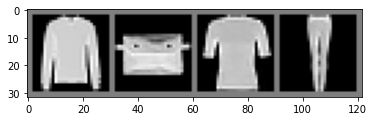

Pullover   Bag T-shirt/top Trouser


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(4)))

2. Define a Convolutional Neural Network


In [4]:
import torch.nn as nn
import torch.nn.functional as F

# CNN: My changes to tutorial code in accordance to the project are indicated with comments
# The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].
# The architecture of your neural network should be 2 conv layers, 32 channels each, where each conv layer will be followed by a ReLU followed by a maxpool. 
# This should be followed by 2 fully connected networks. 
# Apply ReLU after the first fc layer (but not after the last fully connected layer).
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 4)
        self.conv2 = nn.Conv2d(32, 32, 4) #Adjusted for my contribution
        self.pool = nn.MaxPool2d(2, 2) 
        self.pool2 = nn.MaxPool2d(2, 2) #Adjusted for my contribution
        # self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(32 * 4 * 4, 120) #Adjusted for my contribution 32 to match instructions & match 512 in features size for training
        self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10) #only 2 instead of 3 from tutorial

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x)) #Adjusted for my contribution
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc2(x)  #Adjusted for my contribution #Apply ReLU after the first fc layer (but not after the last fully connected layer). 
        # x = self.fc3(x) #only 2 instead of 3 from tutorial
        return x
    # grabbed from the NN tutorial 
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
)


3. Define a Loss function and optimizer

A loss function takes the (output, target) pair of inputs, and computes a value that estimates how far away the output is from the target.


In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #tutorial
# Adjusted for my contribution. Used Adam & adjusted lr/learning rate from 0.001 to 0.01
learning_rate = 0.01 
optimizer = optim.Adam(net.parameters(), lr=learning_rate) 

4. Train the network

In [6]:
# for epoch in range(2):  # loop over the dataset multiple times
#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0
# print('Finished Training')

# Training on GPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
# print(device)
# net.to(device)
# inputs, labels = data[0].to(device), data[1].to(device)

# Run the training loop until convergence.
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Adjusted for my contribution, based on the above commented out template.
device = torch.device('cpu')
net = net.to(device)
print('Device:', device)
batches = []
trainingLoss = []
convergenceThreshold = 0.05
epoch = 0
iteration = 0
mean = 0.0
while True:
    running_loss = 0.0
    total = 0.0
    dataCount = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        total += loss.item()
        dataCount += 1
        if i % 2000 == 1999:    # print every 2000 mini-batches
          print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
          batches.append((i + 1)/2000) #setup for x axis
          trainingLoss.append(running_loss / 2000) #added to display training loss
          running_loss = 0.0
    # Setup convergence
    mean2 = total / dataCount
    if abs(mean2 - mean) < convergenceThreshold:
        iteration += 1
    else:
        iteration = 0
    #If done 3x consecutive iterations are < 0.03 (or if epoch take more than 10x), then stop training here and break
    if iteration >= 3 or epoch > 10:
        break
    #if not, train again
    mean = mean2
    epoch += 1

print('Finished Training')
# Save the trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Device: cpu
[1,  2000] loss: 1.003
[1,  4000] loss: 0.788
[1,  6000] loss: 0.702
[1,  8000] loss: 0.672
[1, 10000] loss: 0.717
[1, 12000] loss: 0.654
[1, 14000] loss: 0.655
[2,  2000] loss: 0.624
[2,  4000] loss: 0.624
[2,  6000] loss: 0.667
[2,  8000] loss: 0.601
[2, 10000] loss: 0.647
[2, 12000] loss: 0.592
[2, 14000] loss: 0.634
[3,  2000] loss: 0.610
[3,  4000] loss: 0.641
[3,  6000] loss: 0.631
[3,  8000] loss: 0.614
[3, 10000] loss: 0.598
[3, 12000] loss: 0.603
[3, 14000] loss: 0.641
[4,  2000] loss: 0.614
[4,  4000] loss: 0.615
[4,  6000] loss: 0.613
[4,  8000] loss: 0.692
[4, 10000] loss: 0.775
[4, 12000] loss: 0.639
[4, 14000] loss: 0.655
[5,  2000] loss: 0.608
[5,  4000] loss: 0.631
[5,  6000] loss: 0.635
[5,  8000] loss: 0.649
[5, 10000] loss: 0.653
[5, 12000] loss: 0.647
[5, 14000] loss: 0.619
Finished Training


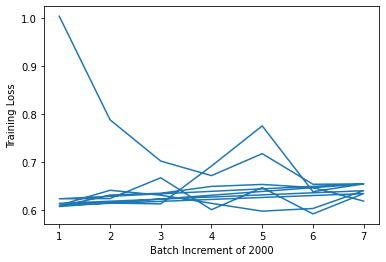

In [7]:
# New contribution
# Plot Training Loss from trainingLoss array
# https://matplotlib.org/tutorials/introductory/pyplot.html
# import matplotlib.pyplot as plt # Imported above
plt.plot(batches, trainingLoss)
plt.xlabel('Batch Increment of 2000')
plt.ylabel('Training Loss')
plt.show()
# print(trainingLoss)

<!-- 5. Test the network on the test data -->

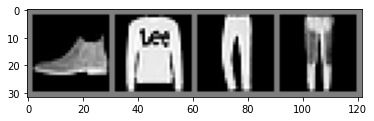

Classification: Ankle boot Pullover Trouser Trouser


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('Classification:', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  Ankle boot Pullover Trouser Trouser


In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 76 %


In [11]:
print("Right/Wrong Classification Started")
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# Adjusted for my contribution. 
# Saves correctly and incorrectly classified images
correctlyClassified = {}
incorrectlyClassified = {}
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # outputs = net(images)
        outputs = net(images.to(device)).data
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            # Adjusted for my contribution. If correctly predicted add to correctlyClassified
            if predicted[i] == labels[i]:
              if not classes[label] in correctlyClassified:
                correctlyClassified[classes[label]] = []
              if len(correctlyClassified[classes[labels[i]]]) < 2:
                correctlyClassified[classes[label]].append((images[i], classes[predicted[i]], classes[label]))
            else: #if incorrectly predicted, add to incorrectlyClassified
              if not classes[label] in incorrectlyClassified:
                incorrectlyClassified[classes[label]] = []
              if len(incorrectlyClassified[classes[labels[i]]]) < 2:
                incorrectlyClassified[classes[label]].append((images[i], classes[predicted[i]], classes[label]))

print("Right/Wrong Classification Started")
# print("Compute a per class accuracy of your classifer.")
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Right/Wrong Classification Started
Right/Wrong Classification Started
Accuracy of T-shirt/top : 74 %
Accuracy of Trouser : 90 %
Accuracy of Pullover : 60 %
Accuracy of Dress : 87 %
Accuracy of  Coat : 74 %
Accuracy of Sandal : 93 %
Accuracy of Shirt : 14 %
Accuracy of Sneaker : 81 %
Accuracy of   Bag : 96 %
Accuracy of Ankle boot : 96 %


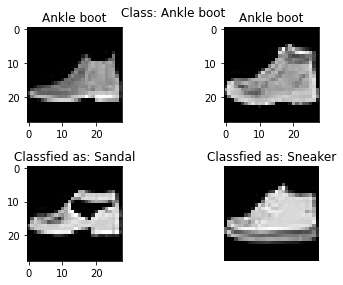

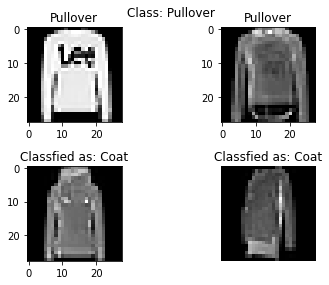

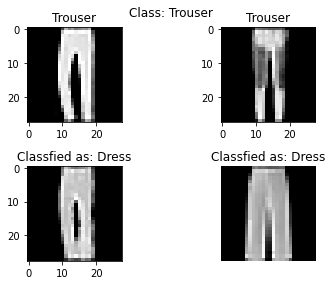

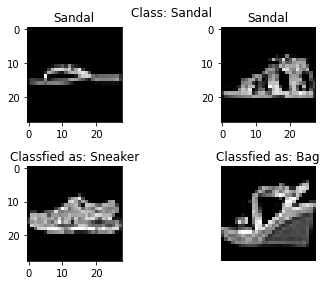

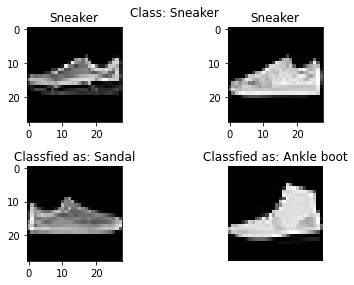

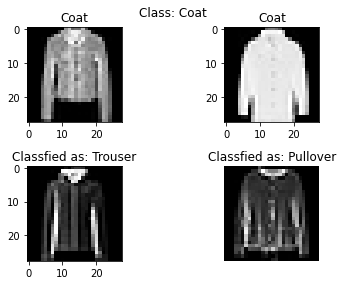

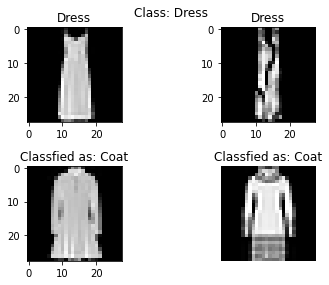

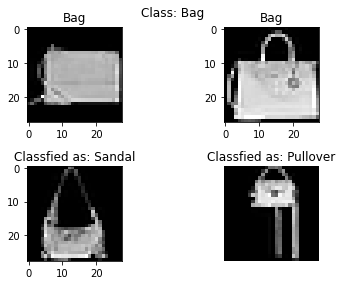

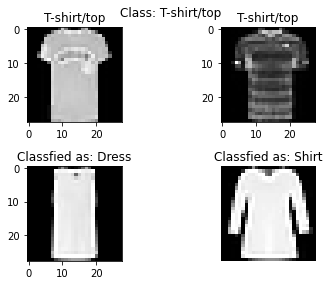

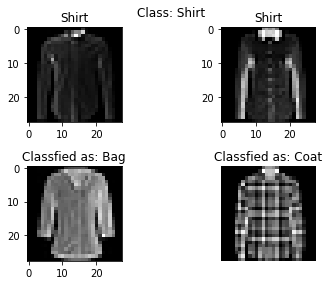

In [12]:
# New contribution
# Display 2 images from each class that is classified correct and 2 where it is classified incorrectly
# https://stackoverflow.com/questions/7066121/how-to-set-a-single-main-title-above-all-the-subplots-with-pyplot/35676071
for class_label in correctlyClassified:
  # print(class_label)
  f, axes = plt.subplots(2, 2)
  plt.suptitle("Class: " + correctlyClassified[class_label][0][1])
  axes[0, 0].set_title(correctlyClassified[class_label][0][1])
  axes[0, 0].imshow(correctlyClassified[class_label][0][0][0], cmap=plt.get_cmap('gray'))
  axes[0, 1].set_title(correctlyClassified[class_label][1][1])
  axes[0, 1].imshow(correctlyClassified[class_label][1][0][0], cmap=plt.get_cmap('gray'))
  axes[1, 0].set_title("Classfied as: " + incorrectlyClassified[class_label][0][1])
  axes[1, 0].imshow(incorrectlyClassified[class_label][0][0][0], cmap=plt.get_cmap('gray'))
  axes[1, 1].set_title("Classfied as: " + incorrectlyClassified[class_label][1][1])
  axes[1, 1].imshow(incorrectlyClassified[class_label][1][0][0], cmap=plt.get_cmap('gray'))
  plt.axis("off")
  plt.tight_layout()

Visualize the learned filters (CNN)

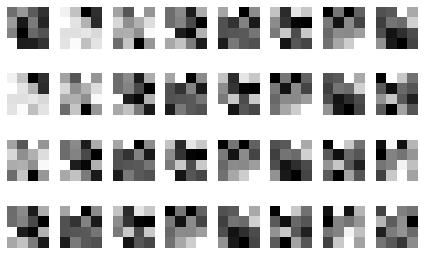

In [13]:
# New contribution
# https://discuss.pytorch.org/t/how-to-visualize-the-actual-convolution-filters-in-cnn/13850
# https://stackoverflow.com/questions/9295026/matplotlib-plots-removing-axis-legends-and-white-spaces
  conv1Weights = net.conv1.weight.data.cpu().numpy()
  f, axes = plt.subplots(4,8) #32
  for x in range(0, 4):
    for y in range(0, 8):
      axes[x, y].axis("off")
      axes[x, y].imshow(conv1Weights[x+y][0], cmap=plt.get_cmap('gray'))
  plt.axis("off")
  plt.tight_layout()